In [20]:
%load_ext autoreload
%autoreload 2

import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import constants
import utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import score_webscraper as sw
import score_prediction as sp

from tqdm.notebook import tqdm

In [15]:
comments_all = sw.get_score_comments(limit=500, verbose=True, offline=True, years=[2024, 2023])

In [16]:
cleaned_comments = [sw.ScoreComment(comment) for comment in tqdm(comments_all)]
data = sp.get_score_df(cleaned_comments)
data = data[np.sort(data.columns)]

  0%|          | 0/810 [00:00<?, ?it/s]

In [17]:
cleaned_comments[101]

{'nbme9': nan, 'nbme10': 226, 'nbme11': 239, 'nbme12': 237, 'nbme13': nan, 'nbme14': 249, 'step 2': 253, 'uwsa 1': 249, 'uwsa 2': 248, 'new free 120': nan, 'old new free 120': 75, 'old old free 120': nan, 'uworld %': 72, 'uworld % (pass 1)': nan, 'uworld % (pass 2)': nan, 'nbme max': 249, 'nbme max2': 239, 'nbme max3': 237, 'nbme range': 23, 'uwsa max': 249, 'uwsa max2': 248, 'free 120 max': 75, 'max practice': 249, 'year': 2024, 'month': 4, 'month_cos_2': -0.5000000000000004, 'status': 'US MD'}


test date: 3/26/2024
us md or us img or non: us img status: us md
step 1: pass
uworld % correct: 72
nbme9: n/a (days out)
nbme10: 226 (25 days out)
nbme11: 239 (20 days out)
nbme12: 237 (17 days out)
nmbe13: 246 (13 days out)
nbme14: 249 (10 days out)
uwsa 1: 249 (8 days out)
uwsa 2: 248 (6 days out)
uwsa 3: n/a (days out)
old old free 120: n/a (days out)
old new free 120: 75% (3 days out)
new free 120: n/a (days out)
cms forms % correct: n/a
predicted score: n/a
total weeks/months studied: 1: 2 months
actual step 2 score: 253
felt terrible leaving the exam, thought i did much worse than my practice exams. so very relieved with my score! probably should've dedicated more time to prep. don't wait to do all your practice exams the month of the exam like i did, i was very burnt out by the end!!

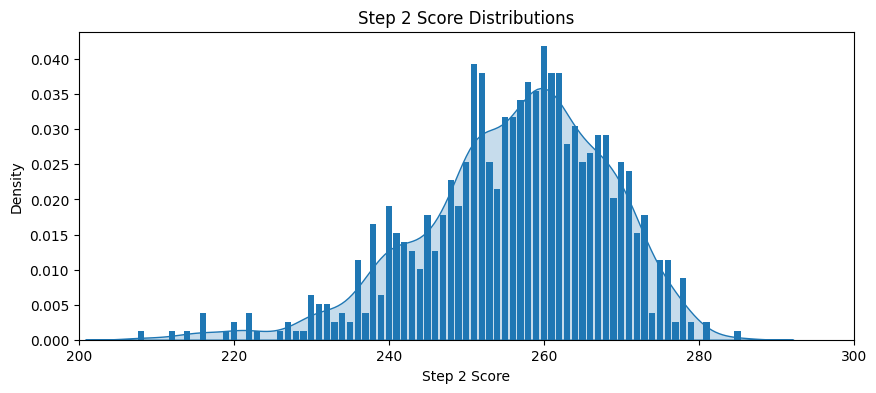

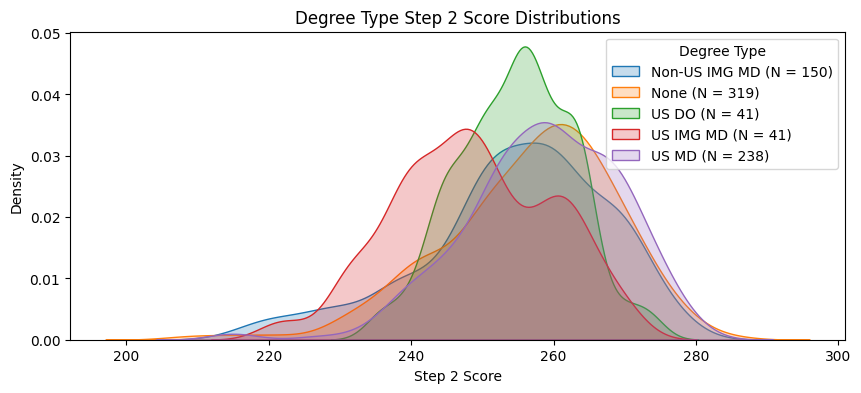

In [21]:
sp.score_dist_plot(data)
sp.degree_type_dist_plot(data)

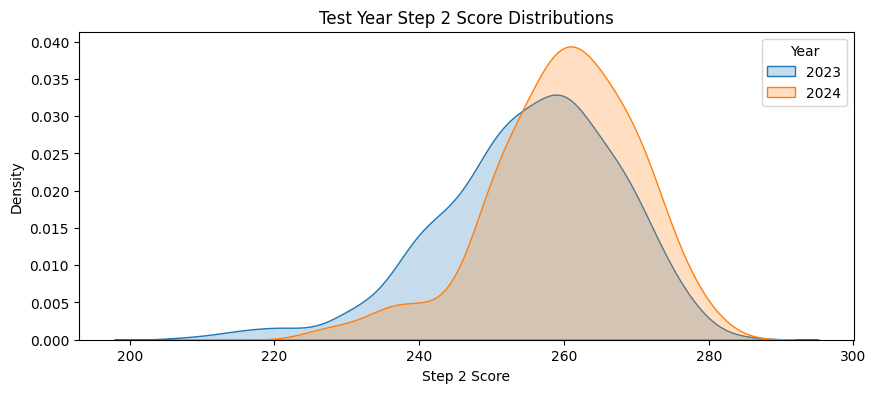

In [22]:
fig, ax = plt.subplots(figsize=(10, 4))
for k, df in data.groupby("year"):
    sns.kdeplot(data=df, x="step 2", fill=True, label=k, ax=ax)
ax.legend(title="Year")
ax.set_xlabel("Step 2 Score")
ax.set_title("Test Year Step 2 Score Distributions")
fig.savefig(os.path.join(constants.PLOT_PATH, "year_score_distributions.png"))

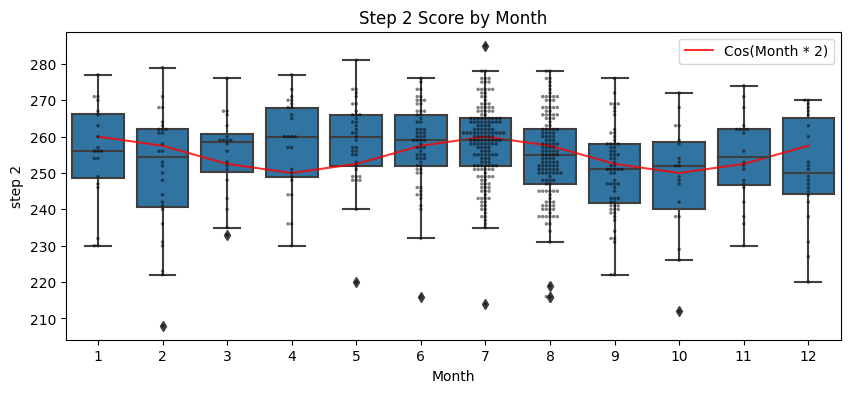

In [23]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.swarmplot(data=data.query("year == 2023"), x="month", y="step 2", ax=ax, color="k", size=2.5, alpha=0.5)
sns.boxplot(data=data.query("year == 2023"), x="month", y="step 2", ax=ax, color="C0")

x = np.arange(12)
ax.plot(x, np.cos(x / 12 * 4 * np.pi) * 5 + 255, color="r", label="Cos(Month * 2)", alpha=0.8)
ax.legend()
ax.set_title("Step 2 Score by Month")
ax.set_xlabel("Month")
fig.savefig(os.path.join(constants.PLOT_PATH, "month_score_distributions.png"))

<Axes: >

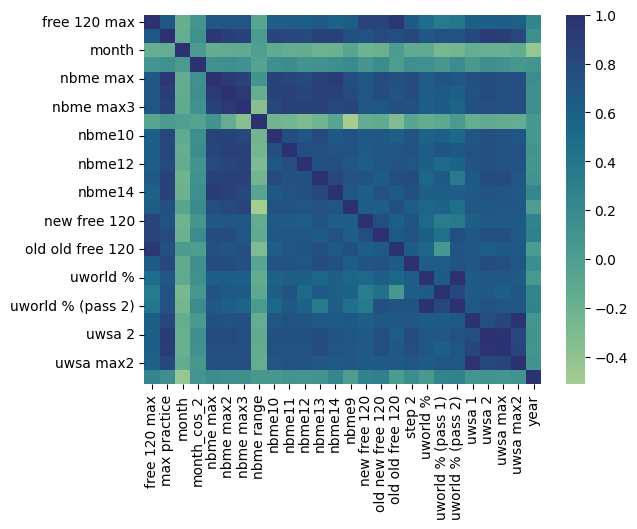

In [24]:
sns.heatmap(data.corr(), cmap="crest")

<Axes: xlabel='uworld % (pass 1)', ylabel='uworld % (pass 2)'>

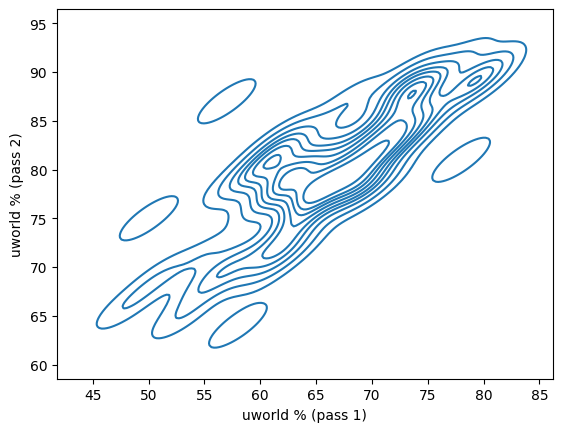

In [25]:
# sns.kdeplot(data=data, x="uworld % (pass 1)", y="uworld % (pass 2)", bw_adjust=0.6)

sns.kdeplot(data=data, x="uworld % (pass 1)", y="uworld % (pass 2)", bw_adjust=0.6)

In [26]:
import scipy

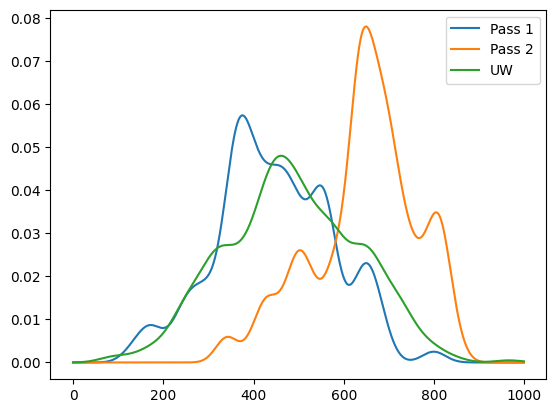

In [27]:
p1_raw = data["uworld % (pass 1)"]
p2_raw = data["uworld % (pass 2)"]
uw_raw = data["uworld %"].loc[p1_raw.isna() & p2_raw.isna()].dropna()

p1_kde = scipy.stats.gaussian_kde(p1_raw.dropna(), bw_method=0.2)
p2_kde = scipy.stats.gaussian_kde(p2_raw.dropna(), bw_method=0.2)
uw_kde = scipy.stats.gaussian_kde(uw_raw.dropna(), bw_method=0.2)


x = np.linspace(40, 100, 1000)
p1_y, p2_y, uw_y = p1_kde(x), p2_kde(x), uw_kde(x)

plt.plot(p1_y, label="Pass 1")
plt.plot(p2_y, label="Pass 2")
plt.plot(uw_y, label="UW")
plt.legend()

In [28]:
v = data["new free 120"].dropna().values

In [29]:
x = np.arange(50, 100)

f120_values = data["new free 120"].dropna().values
free_120_percentile = np.vectorize(lambda x_i: np.nan if np.isnan(x_i) else np.mean(f120_values <= x_i) * 100)

uw_values = data["uworld %"].dropna().values
uw_percentile = np.vectorize(lambda x_i: np.nan if np.isnan(x_i) else np.mean(uw_values <= x_i) * 100)

max_practice = data["max practice"].dropna().values
mp_percentile = np.vectorize(lambda x_i: np.nan if np.isnan(x_i) else np.mean(max_practice <= x_i) * 100)

y = [np.mean(v < x_i) for x_i in x]

In [30]:
data["uw percentile"] = uw_percentile(data["uworld %"])
data["free 120 percentile"] = free_120_percentile(data["new free 120"])
data["max practice percentile"] = mp_percentile(data["max practice"])

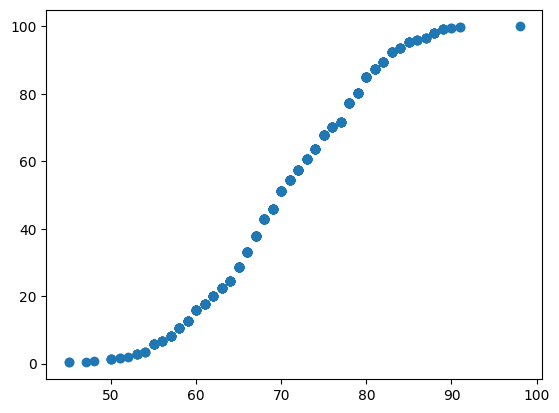

In [31]:
plt.scatter(uw_values, uw_percentile(uw_values))

# Prediction 

In [32]:
import statsmodels.api as sm
import sklearn.metrics

In [33]:
data["US MD"] = (data["status"] == "US MD") * 1
data["Degree None"] = (data["status"] == "None") * 1

In [34]:
x_vars = ["max practice", "year", "month_cos_2", "US MD"] #"nbme range], "uw percentile"] #, "Degree None"]
x_vars += ["uworld %"]

y_var = ["step 2"]

In [35]:
x_vars

['max practice', 'year', 'month_cos_2', 'US MD', 'uworld %']

In [36]:
loc = (data["step 2"] > 225)
loc = loc & data["status"].isin(["US MD", "None"])

df = data
df = df.loc[loc]
df = df[x_vars + y_var].dropna()

x, y = df[x_vars], df[y_var]

x_fit = sm.add_constant(x)
fit_results = sm.OLS(y, x_fit).fit()
fit_results.summary(slim=True)
y_p = fit_results.predict(x_fit)

sklearn.metrics.r2_score(y, y_p)
fit_results.summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 step 2   R-squared:                       0.724
Model:                            OLS   Adj. R-squared:                  0.720
No. Observations:                 342   F-statistic:                     176.1
Covariance Type:            nonrobust   Prob (F-statistic):           1.33e-91
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -4302.0758   1506.891     -2.855      0.005   -7266.206   -1337.946
max practice     0.5642      0.031     17.929      0.000       0.502       0.626
year             2.1767      0.745      2.921      0.004       0.711       3.643
month_cos_2      0.5873      0.457      1.286      0.199      -0.311       1.486
US MD            1.4475      0.627      2.310      0.021       0.215       2.680
uworld %         0.1596      0.045      3.513      0.001       0.070       0.249
================================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.97e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [37]:
def bounds(v):
    return [np.min(v), np.max(v)]

Median Error: 3.8642915566635025
SE of Error 5.651506293164304


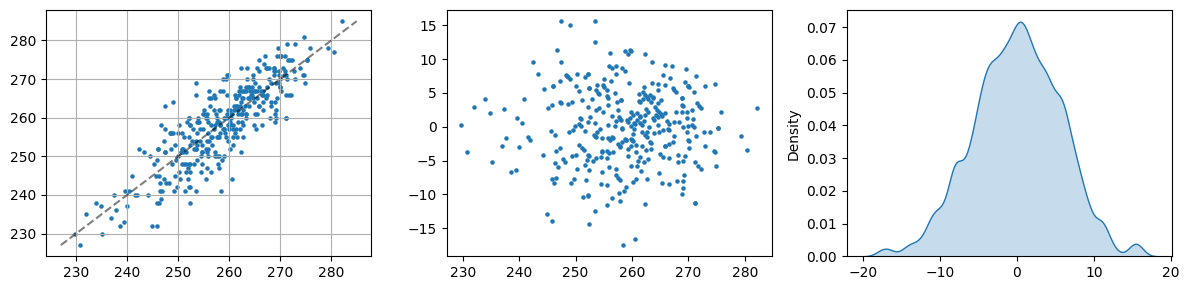

In [40]:
residuals = y.values.reshape(-1) - y_p
print("Median Error:", np.median(np.abs(residuals)))
print("SE of Error", np.std(residuals))

fig, axes = plt.subplots(figsize=(12, 3), ncols=3)
axes[1].scatter(y_p, residuals, s=5)
sns.kdeplot(residuals, ax=axes[2], fill=True, bw_adjust=0.5)

axes[0].scatter(y_p, y, s=5)
axes[0].plot(bounds(y.values), bounds(y.values), color="k", alpha=0.5, linestyle="--")
axes[0].grid() #axis='x', color='0.95')
fig.tight_layout()

In [41]:
print("80% CI: ({:0.1f}, {:0.1f})".format(np.percentile(residuals, 10), np.percentile(residuals, 90)))
print("90% CI: ({:0.1f}, {:0.1f})".format(np.percentile(residuals, 5), np.percentile(residuals, 95)))
print("95% CI: ({:0.1f}, {:0.1f})".format(np.percentile(residuals, 2.5), np.percentile(residuals, 97.5)))

80% CI: (-7.7, 7.0)
90% CI: (-9.5, 8.9)
95% CI: (-11.2, 10.8)


In [42]:
def percentile(dist, values):
    return np.array([np.nan if np.isnan(v) else np.mean(dist <= v) for v in values])

In [43]:
z_vars = constants.NBME_SCORE_KEYS + ["uwsa 1", "uwsa 2", "uworld %", "new free 120"]
y_var = ["step 2"]

loc = (data["step 2"] > 200)
# loc = loc & data["status"].isin(["US MD", "None"])


z_data = {}
for z_var in z_vars + y_var:
    z_data[z_var] = percentile(data.loc[loc][z_var], data.loc[loc][z_var])

zdf = pd.DataFrame(z_data)

In [44]:
zdf["nbme max"] = np.nanmax(zdf[constants.NBME_SCORE_KEYS], axis=1)
zdf["nbme median"] = np.nanmedian(zdf[constants.NBME_SCORE_KEYS], axis=1)
zdf["nbme mean"] = np.nanmean(zdf[constants.NBME_SCORE_KEYS], axis=1)
zdf["nbme std"] = np.nanstd(zdf[constants.NBME_SCORE_KEYS], axis=1)

zdf["z max"] = np.nanmax(zdf[z_vars], axis=1)
zdf["z median"] = np.nanmedian(zdf[z_vars], axis=1)
zdf["z mean"] = np.nanmedian(zdf[z_vars], axis=1)
zdf["z std"] = np.nanstd(zdf[z_vars], axis=1)

/var/folders/vy/ng8z35ts71z736pdwsgxy_300000gn/T/ipykernel_21979/4226832014.py:1: RuntimeWarning: All-NaN axis encountered
  zdf["nbme max"] = np.nanmax(zdf[constants.NBME_SCORE_KEYS], axis=1)
/Users/cole/miniconda3/envs/py38/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
/var/folders/vy/ng8z35ts71z736pdwsgxy_300000gn/T/ipykernel_21979/4226832014.py:3: RuntimeWarning: Mean of empty slice
  zdf["nbme mean"] = np.nanmean(zdf[constants.NBME_SCORE_KEYS], axis=1)
/Users/cole/miniconda3/envs/py38/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/vy/ng8z35ts71z736pdwsgxy_300000gn/T/ipykernel_21979/4226832014.py:6: RuntimeWarning: All-NaN axis encountered
  zdf["z max"] = np.nanmax(zdf[z_vars], axis=1)
/Users/cole/miniconda3/envs/py38/l

In [45]:
zdf.corr()["step 2"].sort_values()

nbme std        0.381346
z std           0.406925
uworld %        0.621979
nbme9           0.648187
uwsa 1          0.701698
new free 120    0.703200
nbme12          0.717191
nbme10          0.719242
nbme11          0.732985
nbme max        0.740466
nbme median     0.754514
nbme mean       0.761724
z max           0.763700
nbme14          0.767151
nbme13          0.769005
z mean          0.777936
z median        0.777936
uwsa 2          0.787458
step 2          1.000000
Name: step 2, dtype: float64

<Axes: xlabel='z max', ylabel='step 2'>

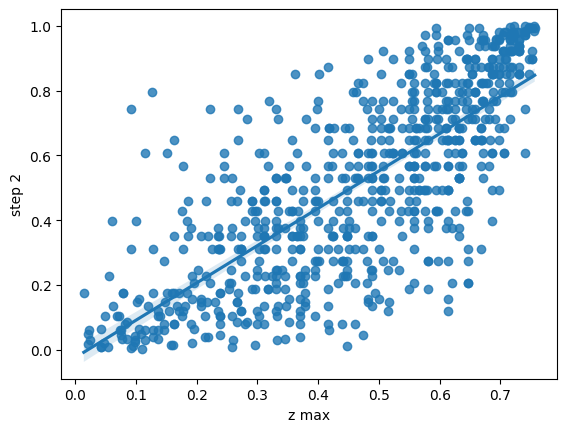

In [46]:
sns.regplot(data=zdf, x="z max", y="step 2")

In [47]:
zx_vars = ["z median"]
zy_var = ["step 2"]

In [48]:
df = zdf
df = df[zx_vars + zy_var].dropna()

x, y = df[zx_vars], df[zy_var]

x_fit = sm.add_constant(x)
fit_results = sm.OLS(y, x_fit).fit()
fit_results.summary(slim=True)
y_p = fit_results.predict(x_fit)

sklearn.metrics.r2_score(y, y_p)
fit_results.summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 step 2   R-squared:                       0.605
Model:                            OLS   Adj. R-squared:                  0.605
No. Observations:                 760   F-statistic:                     1162.
Covariance Type:            nonrobust   Prob (F-statistic):          4.02e-155
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1224      0.013      9.268      0.000       0.096       0.148
z median       1.2341      0.036     34.086      0.000       1.163       1.305
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [49]:
res = y.values.reshape(-1) - y_p.values.reshape(-1)
np.median(np.abs(res))

0.12061126556701303